In [3]:
from transformers import AutoTokenizer
import torch
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import json
from model_wrapper import ModelWrapper, InterventionSettings, Intervention
from utils import format_conversation
from viz import visualize_token_nlls
from collections import defaultdict
from tqdm import tqdm

In [4]:
load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HF_TOKEN")

In [5]:
MODEL_LLAMA_3_CHAT = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_LLAMA_3_CHAT, token=HUGGINGFACE_TOKEN
)

In [7]:
tokenizer.pad_token_id = tokenizer.eos_token_id

In [8]:
model = ModelWrapper()

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [9]:
model.reset_hooks()

In [10]:
messages = [
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "Paris."},
    {"role": "user", "content": "What do people like to eat there?"},
    {"role": "assistant", "content": "People in Paris like to eat croissants and baguettes."},
    {"role": "user", "content": "That's interesting. What about the weather? What is it like in the summer?"},
]

In [11]:
messages_formatted = format_conversation(messages, tokenizer, add_generation_prompt=True)

In [12]:
print(messages_formatted)

<|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [13]:
tokens = tokenizer.encode(messages_formatted, return_tensors="pt")

In [14]:
print(tokenizer.decode(tokens[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [15]:
per_token_nlls = model.get_per_token_nlls(tokens)

In [16]:
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [17]:
role_nlls = model.get_role_nlls(tokens)

In [18]:
for item in role_nlls:
    token_str = tokenizer.decode(item['tokens']).replace('\n', '\\n')
    print(f"{tokenizer.decode(item['role'])} (NLL={item['nll']}): '{token_str}'")

user (NLL=33.5): '\n\nWhat is the capital of France?'
assistant (NLL=8.125): '\n\nParis.'
user (NLL=25.875): '\n\nWhat do people like to eat there?'
assistant (NLL=34.25): '\n\nPeople in Paris like to eat croissants and baguettes.'
user (NLL=50.5): '\n\nThat's interesting. What about the weather? What is it like in the summer?'
assistant (NLL=0.0): '\n\n'


In [19]:
generation = model.sample(tokens.to(model.device), max_n_tokens=500)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [20]:
print(tokenizer.decode(generation[0]))

<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22-25°C (72-77°F) from June to August. However, it's not uncommon to experience occasional heatwaves, and the city can get quite crowded during the peak tourist season.<|eot_id|>


In [21]:
assistant_token_embedding = model.assistant_token_embedding
user_token_embedding = model.user_token_embedding

In [79]:
intervention = InterventionSettings(
    intervention=Intervention.STEER_AT_LAYER,
    user_vector=user_token_embedding,
    assistant_vector=assistant_token_embedding,
    layer=10
)

In [80]:
model.set_intervention(intervention)

In [84]:
model.hooks

In [82]:
generation = model.sample(tokens.to(model.device), max_n_tokens=250)
print(tokenizer.decode(generation[0]))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What is the capital of France?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Paris.<|eot_id|><|start_header_id|>user<|end_header_id|>

What do people like to eat there?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

People in Paris like to eat croissants and baguettes.<|eot_id|><|start_header_id|>user<|end_header_id|>

That's interesting. What about the weather? What is it like in the summer?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The weather in Paris can be quite pleasant in the summer. It's usually mild and warm, with average high temperatures ranging from 22-25°C (72-77°F) from June to August. However, it's not uncommon to experience occasional heatwaves, and the city can get quite crowded and humid during the peak tourist season. But overall, the summer weather in Paris is lovely, with plenty of sunshine and long days.<|eot_id|>


In [83]:
per_token_nlls = model.get_per_token_nlls(tokens)
visualize_token_nlls(tokens[0].cpu(), per_token_nlls[0].cpu().float(), tokenizer)

In [29]:
def get_msj_nlls(model: ModelWrapper, dataset_path: str, intervention: InterventionSettings | None = None):
    with open(dataset_path) as f:
        dataset = json.load(f)
    result = defaultdict(list)
    for row in tqdm(dataset):
        tokens = torch.tensor(row["tokens"]).to(model.device)
        nlls = model.get_role_nlls(tokens)
        result[row['n_shots']].append(nlls)
    result_save_path = dataset_path.replace("processed_data", "results")
    if intervention is not None:
        result_save_path = result_save_path.replace(".json", f"_{intervention}.json")
    os.makedirs(os.path.dirname(result_save_path), exist_ok=True)
    with open(result_save_path, "w") as f:
        json.dump(result, f)
    return result

In [30]:
model.reset_hooks()
msj_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json")
msj_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_recovery.json")
msj_mean_jailbreak_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json")
msj_mean_recovery_nlls = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json")

100%|██████████| 240/240 [00:41<00:00,  5.81it/s]


In [99]:
def plot_nlls(results, legend, figsize=(7, 4), title = None):
    fig, ax = plt.subplots(figsize=figsize)
    for r, l in zip(results, legend):
        data = sorted([
            (k, sum([r[-1]['nll'] for r in v])/len(v)) for k, v in r.items()
        ])
        shots, nlls = zip(*data)
        shots = np.array(shots)
        ax.plot(shots, nlls, 'o-', markersize=5, label=l)
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    ax.set_xlabel('Number of shots')
    ax.set_ylabel('NLL of final assistant response')    
    ax.legend()
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

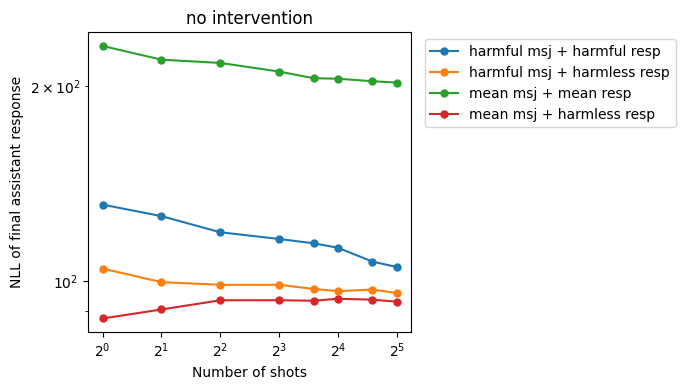

In [101]:
plot_nlls([msj_jailbreak_nlls, msj_recovery_nlls, msj_mean_jailbreak_nlls, msj_mean_recovery_nlls], ['harmful msj + harmful resp', 'harmful msj + harmless resp', 'mean msj + mean resp', 'mean msj + harmless resp'], title="no intervention")

In [ ]:
interventions = [
    InterventionSettings(
        intervention=Intervention.RESID_ADD_PROJECT,
        user_vector=user_token_embedding*0.1,
        assistant_vector=assistant_token_embedding*0.1,
    ),
    InterventionSettings(
        intervention=Intervention.EMBEDDING_COLOR,
        user_vector=user_token_embedding*0.6,
        assistant_vector=assistant_token_embedding*0.6,
    ),
    InterventionSettings(
        intervention=Intervention.STEER_AT_LAYER,
        user_vector=user_token_embedding*0.5,
        assistant_vector=assistant_token_embedding*0.5,
        layer=10
    ),
    InterventionSettings(
        intervention=Intervention.STEER_AT_LAYER,
        user_vector=user_token_embedding*0.5,
        assistant_vector=assistant_token_embedding*0.5,
        layer=5
    ),
    InterventionSettings(
        intervention=Intervention.STEER_AT_LAYER,
        user_vector=user_token_embedding*0.5,
        assistant_vector=assistant_token_embedding*0.5,
        layer=20
    )
]

In [ ]:
for i in interventions:
    model.set_intervention(i)
    msj_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_jailbreak.json", intervention=1)
    msj_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_recovery.json", intervention=1)
    msj_mean_jailbreak_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_jailbreak.json", intervention=1)
    msj_mean_recovery_nlls_colored = get_msj_nlls(model, "processed_data/test/msjs_mean_recovery.json", intervention=1)
    plot_nlls([msj_jailbreak_nlls_colored, msj_jailbreak_nlls], ['(color) harmful msj + harmful resp', 'harmful msj + harmful resp'], title=str(i))
    plot_nlls([msj_recovery_nlls_colored, msj_recovery_nlls], ['(color) harmful msj + harmless resp', 'harmful msj + harmless resp'], title=str(i))
    plot_nlls([msj_mean_jailbreak_nlls_colored, msj_mean_jailbreak_nlls], ['(color) mean msj + harmful resp', 'mean msj + harmful resp'], title=str(i))
    plot_nlls([msj_mean_recovery_nlls_colored, msj_mean_recovery_nlls], ['(color) mean msj + harmless resp', '(mean msj + harmless resp'], title=str(i))